In [1]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from cv2 import cv2

In [2]:
base_path = Path(os.path.abspath(''))
path = base_path / 'detections.prqt'
median_path = base_path / 'median.jpg'

assert path.exists(), 'Data should be available in same directory as the notebook'
assert median_path.exists(), 'Image should be available in same directory as the notebook'

In [3]:
img_median = cv2.imread(str(median_path), cv2.IMREAD_GRAYSCALE)
frame_size = img_median.shape
image = np.zeros(frame_size)

In [4]:
def plot_rects(imgage, df, filled=True):
    img = imgage.copy()
    for i, row in df.iterrows():            
        pt1 = (int(row.x), int(row.y))
        pt2 = (int(row.x2), int(row.y2))
        if filled:
            img = cv2.rectangle(img,pt1,pt2,1, cv2.FILLED)
        else:
            img = cv2.rectangle(img,pt1,pt2,1, thickness=3)
    img = img.astype(np.uint8)

    plt.imshow(img, cmap='gray')
    return img

##### This is the original image

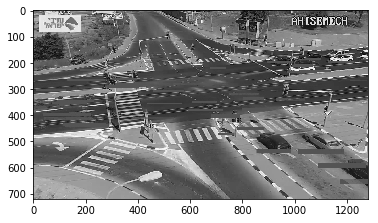

In [5]:
img_median = cv2.imread(str(median_path),cv2.IMREAD_GRAYSCALE)
plt.imshow(img_median, cmap='gray')

Loading the data, and adding (x2, y2) point - for easier handling

In [6]:
filters = None
columns = None
data_set = pq.ParquetDataset(str(path), filters=filters)
pdf = data_set.read(columns=columns)
df = pdf.to_pandas()[['x', 'y', 'w', 'h', 'label']]
df.loc[:,'x2'] = df.x + df.w
df.loc[:,'y2'] = df.y + df.h
df.head()

,x,y,w,h,label,x2,y2
0,113,396,163,45,car,276,441
1,778,386,104,73,car,882,459
2,1014,451,167,98,car,1181,549
3,400,67,27,21,car,427,88
4,1129,167,99,34,car,1228,201


##### Find the extream detections

In [7]:
def group_boundary_detections(df, field_name, quantile, edge_type):      
    series = df[field_name]
    
    q_value = series.quantile(quantile)     
    idxs = series < q_value if quantile < 0.5 else series > q_value
    arg_function = pd.Series.idxmax if quantile < 0.5 else pd.Series.idxmin
    selected_boxes = df[idxs]
    ret =  selected_boxes.agg({'x':'min', 'y':'min','x2':'max', 'y2':'max'})
    ret['edge_type'] = edge_type
    return ret

(720, 1280)


,x,y,x2,y2,edge_type
0,-4,227,157,460,left
1,360,0,473,15,top
2,1169,132,1286,664,right
3,397,567,1286,719,bottom


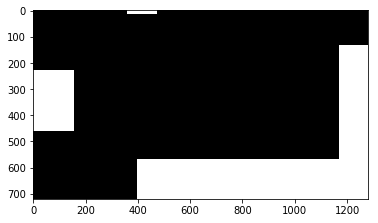

In [8]:
quantile = 0.95
left_most = group_boundary_detections(df, 'x', 1-quantile, 'left')#df.loc[df.x.idxmin()]#
top_most = group_boundary_detections(df, 'y', 1-quantile, 'top')#df.loc[df.y.idxmin()]
right_most =  group_boundary_detections(df, 'x', quantile, 'right')#df.loc[df.x.idxmax()]
bottom_most =  group_boundary_detections(df, 'y', quantile, 'bottom')#df.loc[df.y.idxmax()]

df_extremes = pd.DataFrame([left_most, 
                            top_most, 
                            right_most, 
                            bottom_most])



print(frame_size)
img_near_edge = plot_rects(image, df_extremes)
df_extremes

##### And figure out which detections are "close"
Also, group the detections that are "edge-ish" (top / bottom / left/ right)

A detection might belong to more than one edge

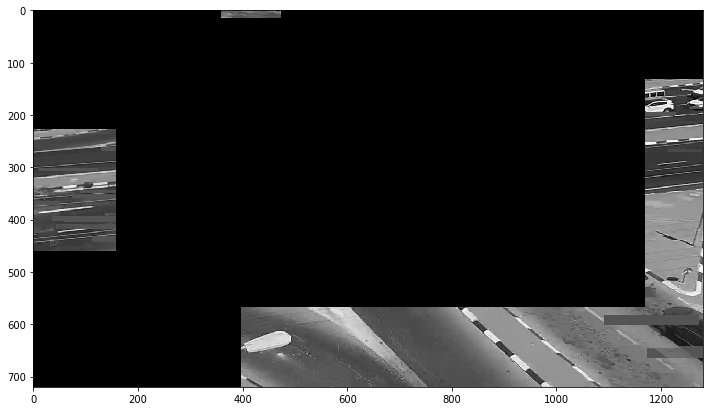

In [9]:
# plt.imshow(img_median, cmap='gray')
plt.figure(figsize = (12,8))
res = cv2.bitwise_or(img_median,img_median,mask=img_near_edge)
plt.imshow(res, cmap='gray', interpolation='nearest')

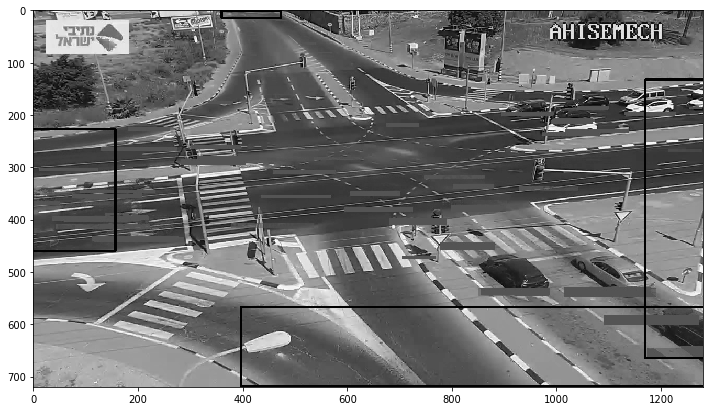

In [10]:
plt.figure(figsize = (12,8))
masked_median = cv2.bitwise_or(img_median,img_median,mask=img_near_edge)
marked_median = plot_rects(img_median, df_extremes, filled=False)#marked_median = plot_rects(img_median, df_edges, filled=False)

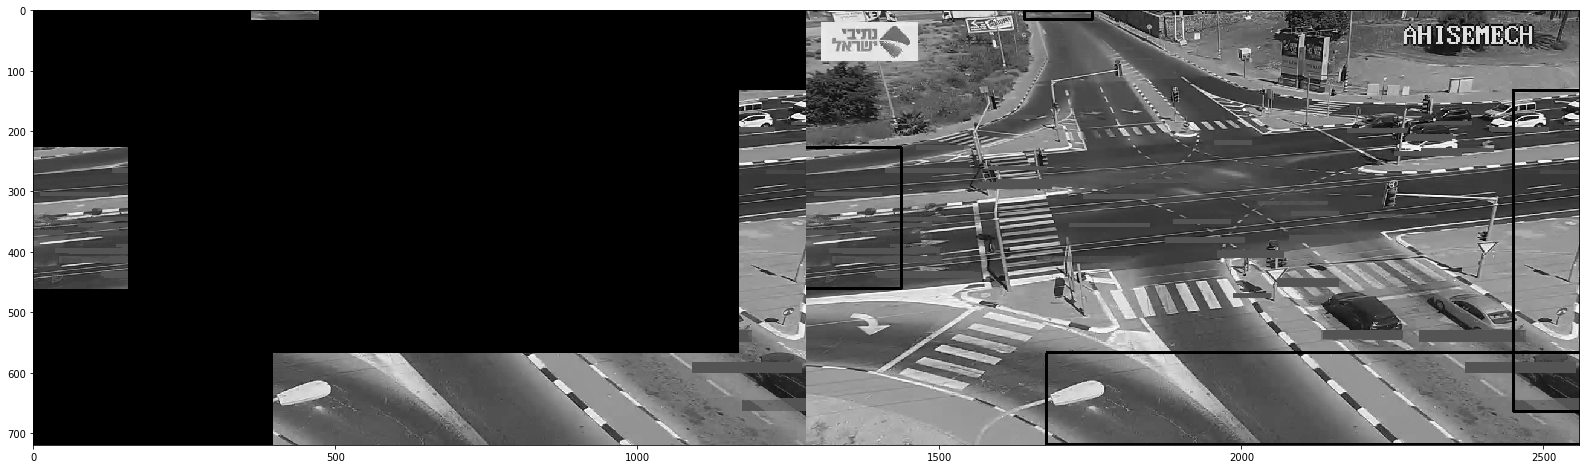

In [11]:
stacked = np.hstack((masked_median, marked_median))  # stacking images side-by-side
aspect = stacked.shape[1]  / stacked.shape[0]
h = 8
w = h * aspect
plt.figure(figsize = (w,h))

plt.imshow(stacked, cmap='gray',  interpolation='nearest')